## PyTorch Image Classification Setup


In [ ]:
import torch
from torch import nn
import torchvision
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

## Load and Transform FashionMNIST Dataset


In [94]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),  
    transforms.ToTensor()
])

train_data = datasets.FashionMNIST(root='Data', train=True, download=True, transform=transform)
test_data = datasets.FashionMNIST(root='Data', train=False, download=True, transform=transform)

## Visualize Random Samples from FashionMNIST


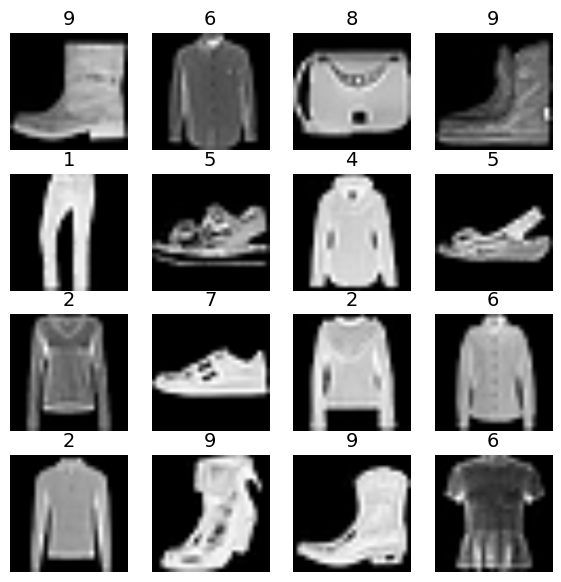

In [95]:
torch.manual_seed(42)
fig = plt.figure(figsize=(7,7))
rows, cols = 4, 4
for i in range(1, rows*cols+1):
  random_idx = torch.randint(0, len(train_data), size=[1]).item()
  img, label = train_data[random_idx]
  fig.add_subplot(rows, cols, i)
  plt.imshow(img.squeeze(), cmap='gray')
  plt.title(label, fontsize=14)
  plt.axis(False)

## Create DataLoaders for Training and Testing


In [96]:
batch_size = 32
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

## Inspect One Batch of Training Data

In [97]:
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape , train_labels_batch.shape

(torch.Size([32, 1, 128, 128]), torch.Size([32]))

## Flatten Image Tensor for Fully Connected Layers


In [98]:
flatten_model = nn.Flatten()
x = train_features_batch[0]
output = flatten_model(x)

print(f"Shape before the flatten layer: {x.shape}")
print(f"Shape after the flatten layer: {output.shape}")

Shape before the flatten layer: torch.Size([1, 128, 128])
Shape after the flatten layer: torch.Size([1, 16384])


## Define a Residual Block for a CNN


In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=stride)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        
        self.skip = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.skip = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )
        
    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        skip = self.skip(x)
        x += skip
        x = self.relu(x)
        return x



## Define CNN Model with Residual Blocks and Adaptive Pooling

In [100]:
class CNNModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            ResidualBlock(1, 32),
            nn.MaxPool2d(2, 2),

            ResidualBlock(32, 64),
            nn.MaxPool2d(2, 2),

            ResidualBlock(64, 128),
            nn.MaxPool2d(2, 2),

            ResidualBlock(128, 256),
            nn.MaxPool2d(2, 2),

            nn.AdaptiveAvgPool2d((1, 1))
        )


        self.layer_1 = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.5), 
            nn.Linear(in_features=256*1*1, out_features=10)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.layer_1(x)
        return x


## Set Device for Training (GPU if Available)


In [101]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Initialize Model, Loss Function, Optimizer, and Accuracy Metric


In [ ]:
model = CNNModelV1().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
accuracy_fn = accuracy_score

## Train the CNN Model for Multiple Epochs with Accuracy Tracking


In [ ]:
from sklearn.metrics import accuracy_score

epochs = 10

for epoch in range(epochs):
    model.train()
    total_loss = 0
    all_preds = []
    all_labels = []

    for X, y in train_dataloader:
        X, y = X.to(device), y.to(device)

        y_pred = model(X)

        loss = loss_fn(y_pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step() 
        total_loss += loss.item()

        preds = torch.argmax(y_pred, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    avg_loss = total_loss / len(train_dataloader)

    print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}, Accuracy: {acc*100:.4f}%")

## Evaluate Model on Test Data and Compute Accuracy


In [ ]:
model.eval()
all_preds = []
all_labels = []
test_loss = 0

with torch.no_grad():
    for X, y in test_dataloader:
        X, y = X.to(device), y.to(device)
        outputs = model(X)
        loss = loss_fn(outputs, y)
        test_loss += loss.item()

        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y.cpu().numpy())

avg_test_loss = test_loss / len(test_dataloader)
acc = accuracy_score(all_labels, all_preds)

print(f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {acc*100:.2f}%")